# Data Preprocessing

In [264]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import scipy.sparse
import joblib
from collections import Counter
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nont\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nont\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nont\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. Load dataset

In [265]:
df = pd.read_json("scicite/train.jsonl", lines=True)

df.head()

source  citeEnd                                        sectionName  \
0  explicit    175.0                                       Introduction   
1  explicit     36.0  Novel Quantitative Trait Loci for Seminal Root...   
2  explicit    228.0                                       Introduction   
3  explicit    110.0                                         Discussion   
4  explicit    239.0                                         Discussion   

   citeStart                                             string       label  \
0      168.0  However, how frataxin interacts with the Fe-S ...  background   
1       16.0  In the study by Hickey et al. (2012), spikes w...  background   
2      225.0  The drug also reduces catecholamine secretion,...  background   
3       46.0  By clustering with lowly aggressive close kin ...  background   
4      234.0  Ophthalmic symptoms are rare manifestations of...  background   

   label_confidence                             citingPaperId  \
0               1.0  1872080baa7d30ec8fb87be9a65358cd3a7fb649   
1               1.0  ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b   
2               1.0  9cdf605beb1aa1078f235c4332b3024daa8b31dc   
3               1.0  d9f3207db0c79a3b154f3875c9760cc6b056904b   
4               1.0  88b86556857f4374842d2af2e359576806239175   

                               citedPaperId  isKeyCitation  \
0  894be9b4ea46a5c422e81ef3c241072d4c73fdc0           True   
1  b6642e19efb8db5623b3cc4eef1c5822a6151107           True   
2  4e6a17fb8d7a3cada601d942e22eb5da6d01adbd          False   
3  2cc6ff899bf17666ad35893524a4d61624555ed7          False   
4  a5bb0ff1a026944d2a47a155462959af2b8505a8          False   

                                                  id  \
0  1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...   
1  ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...   
2  9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...   
3  d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...   
4  88b86556857f4374842d2af2e359576806239175>a5bb0...   

                                           unique_id  excerpt_index label2  \
0  1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...             11    NaN   
1  ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...              2    NaN   
2  9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...              0    NaN   
3  d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...              3    NaN   
4  88b86556857f4374842d2af2e359576806239175>a5bb0...              2    NaN   

   label2_confidence  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN

In [266]:
df.describe()

citeEnd    citeStart  label_confidence  excerpt_index  \
count  8241.000000  8241.000000       6137.000000    8243.000000   
mean    163.965781   139.709744          0.876606       2.333495   
std     121.478095    79.479383          0.144244       3.326236   
min       3.000000     0.000000          0.600000       0.000000   
25%     103.000000    87.000000          0.744700       0.000000   
50%     152.000000   134.000000          1.000000       1.000000   
75%     208.000000   187.000000          1.000000       3.000000   
max    3305.000000  1184.000000          1.000000      19.000000   

       label2_confidence  
count         317.000000  
mean            0.741582  
std             0.191581  
min             0.249800  
25%             0.616900  
50%             0.738500  
75%             1.000000  
max             1.000000

## 2. Features Processing

* Source: text -> Categorical (int)
* CiteEnd: float -> int
* CiteStart: float -> int
* SectionName: text -> Categorical (int)
* string: text -> embedding (vectorized)
* label: text -> categorical (int)
* iskeyCitation: Bool -> category (id)
* exerpt index

In [267]:
def show_matches(pattern, string, flags=0):
    # Compile RegEx pattern
    p = re.compile(pattern, flags=flags)
    # Match pattern against input text
    matches = list(p.finditer(string))
    # Handle matches
    if len(matches) == 0:
        return False
    else:
        return True
        # print(' | '.join([ m.group() for m in matches] ), '\n')

In [268]:
for column in df.columns:
    print(f"{column} null value:",sum(df[column].isnull()))

source null value: 2
citeEnd null value: 2
sectionName null value: 19
citeStart null value: 2
string null value: 0
label null value: 0
label_confidence null value: 2106
citingPaperId null value: 0
citedPaperId null value: 0
isKeyCitation null value: 0
id null value: 0
unique_id null value: 0
excerpt_index null value: 0
label2 null value: 7408
label2_confidence null value: 7926


In [269]:
df = df.drop(columns=['label_confidence','citingPaperId','citedPaperId','id','unique_id','label2','label2_confidence'])

In [270]:
# sum(df['source'].isnull())
# df[df['source'].isnull()]
# 2 missing sources
df = df.dropna(subset=['source','sectionName'])
sum(df['source'].isnull())

0

In [271]:
for column in df.columns:
    print(f"{column} null value:",sum(df[column].isnull()))

source null value: 0
citeEnd null value: 0
sectionName null value: 0
citeStart null value: 0
string null value: 0
label null value: 0
isKeyCitation null value: 0
excerpt_index null value: 0


In [272]:
# Initialize Label Encoder
label_encoder = LabelEncoder()

# Encode labels (e.g., 'Background' → 0, 'Method' → 1, 'Result' → 2)
df["source_encoded"] = label_encoder.fit_transform(df["source"])

# Show label mappings
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Source Mapping:", label_mapping)

Source Mapping: {'acronym': np.int64(0), 'acronymParen': np.int64(1), 'andPhrase': np.int64(2), 'etAlPhrase': np.int64(3), 'explicit': np.int64(4), 'properNoun': np.int64(5)}


In [273]:
df.loc[:, 'citeStart'] = df['citeStart'].astype(np.int64)

In [274]:
df.loc[:,'citeEnd'] = df['citeEnd'].astype(np.int64)

In [275]:
def lower(text):
    text = text.lower()
    return text

In [276]:
sum(df['sectionName'].isnull())

0

In [277]:
df.loc[:,'sectionName'] = df['sectionName'].apply(lower)

In [278]:
len(df['sectionName'].unique())

1074

In [287]:
df[df['sectionName']== '']

source  citeEnd sectionName  citeStart  \
16    explicit    128.0                  119.0   
28    explicit    112.0                  108.0   
31    explicit    177.0                  123.0   
49    explicit    131.0                  101.0   
50    explicit    251.0                  228.0   
...        ...      ...         ...        ...   
8180  explicit    144.0                  140.0   
8206  explicit    213.0                  209.0   
8235  explicit      6.0                    3.0   
8238  explicit     50.0                   28.0   
8241  explicit    221.0                  185.0   

                                                 string       label  \
16    Nevertheless, there is no high-quality evidenc...  background   
28    The language models were characterN-grams trai...      method   
31    However, localization of additional γ-tubulin ...  background   
49    A series of genes (termed exo) involved in suc...  background   
50    The main distribution of 13-galactosidase-prod...  background   
...                                                 ...         ...   
8180  For more details on EDC calculation, forwarder...  background   
8206  The validity of long-term recall of childhood ...  background   
8235  In [5], Sigurjonsson and Kim obtained bounds o...  background   
8238  Importantly, the results of Pascalis et al. (2...  background   
8241  ACTIVATION OF TRANSCRIPTION FACTORS Roles for ...      method   

      isKeyCitation  excerpt_index  source_encoded  
16             True              0               4  
28             True              1               4  
31            False              4               4  
49             True              3               4  
50            False              2               4  
...             ...            ...             ...  
8180          False             13               4  
8206          False              0               4  
8235           True              2               4  
8238           True             15               4  
8241           True              0               4  

[587 rows x 9 columns]

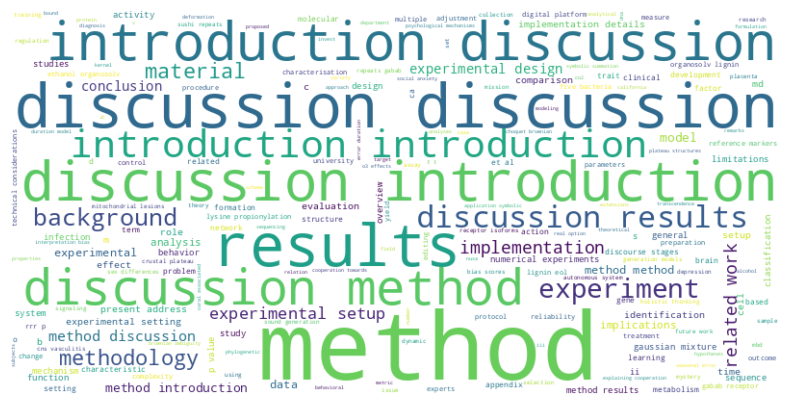

In [249]:
text = " ".join(df['sectionName'].tolist())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [250]:
stop_words = set(stopwords.words("english"))
# lemmatizing
lemmatizer = WordNetLemmatizer()


# Tokenize and remove stopwords
words = [word.lower() for text in df['sectionName'] for word in text.split() if word.lower() not in stop_words]
lemmatized_word = [lemmatizer.lemmatize(word) for word in words]
# Get most common words
word_counts = Counter(words).most_common(100)
word_counts

[('discussion', 2205),
 ('introduction', 1685),
 ('methods', 1326),
 ('results', 761),
 ('1.', 415),
 ('4.', 228),
 ('1', 179),
 ('experiments', 156),
 ('2.', 138),
 ('method', 130),
 ('3.', 129),
 ('background', 125),
 ('experimental', 121),
 ('methodology', 88),
 ('materials', 88),
 ('2', 86),
 ('4', 74),
 ('implementation', 69),
 ('setup', 65),
 ('5', 64),
 ('related', 60),
 ('work', 60),
 ('3', 56),
 ('6', 48),
 ('5.', 43),
 ('design', 42),
 ('model', 34),
 ('a.', 27),
 ('7', 26),
 ('2.2', 25),
 ('analysis', 23),
 ('experiment', 22),
 ('evaluation', 22),
 ('6.', 21),
 ('4.2.', 21),
 ('4.1', 21),
 ('data', 21),
 ('implications', 20),
 ('2.1', 20),
 ('3.1', 20),
 ('conclusions', 20),
 ('3.2', 19),
 ('2.2.', 18),
 ('2.1.', 18),
 ('identification', 18),
 ('3.2.', 16),
 ('cell', 16),
 ('role', 16),
 ('present', 15),
 ('details', 15),
 ('system', 15),
 ('effects', 15),
 ('conclusion', 15),
 ('address:', 14),
 ('settings', 14),
 ('overview', 14),
 ('3.1.', 14),
 ('learning', 13),
 ('4.2',

In [251]:
word_counts = Counter(lemmatized_word).most_common(100)
word_counts

[('discussion', 2207),
 ('introduction', 1685),
 ('method', 1456),
 ('result', 761),
 ('1.', 415),
 ('4.', 228),
 ('1', 179),
 ('experiment', 178),
 ('2.', 138),
 ('3.', 129),
 ('background', 125),
 ('experimental', 121),
 ('material', 92),
 ('methodology', 88),
 ('2', 86),
 ('4', 74),
 ('implementation', 69),
 ('setup', 65),
 ('work', 64),
 ('5', 64),
 ('related', 60),
 ('3', 56),
 ('6', 48),
 ('5.', 43),
 ('design', 43),
 ('model', 40),
 ('conclusion', 35),
 ('analysis', 27),
 ('a.', 27),
 ('7', 26),
 ('cell', 25),
 ('2.2', 25),
 ('study', 24),
 ('setting', 24),
 ('system', 22),
 ('evaluation', 22),
 ('6.', 21),
 ('4.2.', 21),
 ('4.1', 21),
 ('data', 21),
 ('implication', 20),
 ('2.1', 20),
 ('3.1', 20),
 ('effect', 19),
 ('3.2', 19),
 ('2.2.', 18),
 ('2.1.', 18),
 ('identification', 18),
 ('3.2.', 16),
 ('role', 16),
 ('present', 15),
 ('detail', 15),
 ('comparison', 15),
 ('mechanism', 14),
 ('address:', 14),
 ('overview', 14),
 ('3.1.', 14),
 ('learning', 13),
 ('4.2', 13),
 ('num

In [252]:
filtered_word_counts = []
for i in word_counts:
    if not show_matches("^[\d.]+$|^\d+(\.\d+)?$|^\d+$]",i[0]): 
        filtered_word_counts.append(i)

In [253]:
filtered_word_counts
# handpick the word
# discussion,introduction,method,result,experiment,background,related work, conclusion,evaluation

[('discussion', 2207),
 ('introduction', 1685),
 ('method', 1456),
 ('result', 761),
 ('experiment', 178),
 ('background', 125),
 ('experimental', 121),
 ('material', 92),
 ('methodology', 88),
 ('implementation', 69),
 ('setup', 65),
 ('work', 64),
 ('related', 60),
 ('design', 43),
 ('model', 40),
 ('conclusion', 35),
 ('analysis', 27),
 ('a.', 27),
 ('cell', 25),
 ('study', 24),
 ('setting', 24),
 ('system', 22),
 ('evaluation', 22),
 ('data', 21),
 ('implication', 20),
 ('effect', 19),
 ('identification', 18),
 ('role', 16),
 ('present', 15),
 ('detail', 15),
 ('comparison', 15),
 ('mechanism', 14),
 ('address:', 14),
 ('overview', 14),
 ('learning', 13),
 ('numerical', 13),
 ('gaussian', 13),
 ('general', 13),
 ('structure', 11),
 ('sequence', 11),
 ('b.', 11),
 ('mixture', 11),
 ('bias', 10),
 ('protein', 10),
 ('feature', 10),
 ('reference', 10),
 ('factor', 10),
 ('behavior', 10),
 ('bacteria', 10),
 ('approach', 10),
 ('characteristic', 10),
 ('gene', 10),
 ('classification', 

In [256]:
len(df['sectionName'])

8222

In [261]:
sum(df['sectionName'].isnull())

0

In [297]:
df[df['sectionName'] == ""]

source  citeEnd sectionName  citeStart  \
383   explicit     53.0                   49.0   
389   explicit    192.0                  104.0   
395   explicit    513.0                  198.0   
438   explicit    190.0                  178.0   
452   explicit     75.0                   71.0   
...        ...      ...         ...        ...   
8180  explicit    144.0                  140.0   
8206  explicit    213.0                  209.0   
8235  explicit      6.0                    3.0   
8238  explicit     50.0                   28.0   
8241  explicit    221.0                  185.0   

                                                 string       label  \
383   4% of the cells contained in human ADH/dysplas...  background   
389   decussata is similar to those of some long-liv...  background   
395   Imagebased models yielded joint kinematics, ne...      result   
438   However, not every patient has access to suppo...  background   
452   computationally expensive, including DTW [26],...  background   
...                                                 ...         ...   
8180  For more details on EDC calculation, forwarder...  background   
8206  The validity of long-term recall of childhood ...  background   
8235  In [5], Sigurjonsson and Kim obtained bounds o...  background   
8238  Importantly, the results of Pascalis et al. (2...  background   
8241  ACTIVATION OF TRANSCRIPTION FACTORS Roles for ...      method   

      isKeyCitation  excerpt_index  source_encoded matched  
383            True              0               4          
389            True              1               4          
395            True              1               4          
438            True              5               4          
452           False              0               4          
...             ...            ...             ...     ...  
8180          False             13               4          
8206          False              0               4          
8235           True              2               4          
8238           True             15               4          
8241           True              0               4          

[559 rows x 10 columns]

In [ ]:
selected_sectionname = ["discussion","introduction","method","result","experiment","background","related work","conclusion","evaluation"]
# if match then change it if don't then don't change
for row in range(len(df['sectionName'])):
    for i in selected_sectionname:
            print(df['sectionName'][row])
            if df['sectionName'][row] == '':
                  print("enter")
                  df.loc[row,'sectionName'] = df.loc[row,'label']
                #   fill with the label
                
            if show_matches(f"{i}",df['sectionName'][row].lower()): 
                  print("matched")
                  df.loc[row,'sectionName'] = i

introduction
wtf
introduction
matched
introduction
wtf
introduction
wtf
introduction
wtf
introduction
wtf
introduction
wtf
introduction
wtf
introduction
wtf
novel quantitative trait loci for seminal root traits in barley
wtf
novel quantitative trait loci for seminal root traits in barley
wtf
novel quantitative trait loci for seminal root traits in barley
wtf
novel quantitative trait loci for seminal root traits in barley
wtf
novel quantitative trait loci for seminal root traits in barley
wtf
novel quantitative trait loci for seminal root traits in barley
wtf
novel quantitative trait loci for seminal root traits in barley
wtf
novel quantitative trait loci for seminal root traits in barley
wtf
novel quantitative trait loci for seminal root traits in barley
wtf
introduction
wtf
introduction
matched
introduction
wtf
introduction
wtf
introduction
wtf
introduction
wtf
introduction
wtf
introduction
wtf
introduction
wtf
discussion
matched
discussion
wtf
discussion
wtf
discussion
wtf
discussion

C:\Users\nont\AppData\Local\Temp\ipykernel_27412\1502566501.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['matched'][row] = df['sectionName'][row].lower()
C:\Users\nont\AppData\Local\Temp\ipykernel_27412\1502566501.py:16: SettingWi

1 introduction
wtf
1 introduction
wtf
1 introduction
wtf
1 introduction
wtf
1 introduction
wtf
1 introduction
wtf
results
wtf
results
wtf
results
wtf
results
matched
results
wtf
results
wtf
results
wtf
results
wtf
results
wtf
2. methods
wtf
2. methods
wtf
2. methods
matched
2. methods
wtf
2. methods
wtf
2. methods
wtf
2. methods
wtf
2. methods
wtf
2. methods
wtf
4. discussion
matched
4. discussion
wtf
4. discussion
wtf
4. discussion
wtf
4. discussion
wtf
4. discussion
wtf
4. discussion
wtf
4. discussion
wtf
4. discussion
wtf
method
wtf
method
wtf
method
matched
method
wtf
method
wtf
method
wtf
method
wtf
method
wtf
method
wtf
personality as a risk factor for alcohol-related behavior
wtf
personality as a risk factor for alcohol-related behavior
wtf
personality as a risk factor for alcohol-related behavior
wtf
personality as a risk factor for alcohol-related behavior
wtf
personality as a risk factor for alcohol-related behavior
wtf
personality as a risk factor for alcohol-related behavio

C:\Users\nont\AppData\Local\Temp\ipykernel_27412\1502566501.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['matched'][row] = df['sectionName'][row].lower()
C:\Users\nont\AppData\Local\Temp\ipykernel_27412\1502566501.py:16: SettingWi

KeyError: 371

In [ ]:
df['section_matching']

0       introduction
1       introduction
2       introduction
3       introduction
4       introduction
            ...     
8238    introduction
8239    introduction
8240    introduction
8241    introduction
8242    introduction
Name: section_matching, Length: 8222, dtype: object

In [ ]:
len(df['sectionName'])

8222

In [ ]:
df.describe()

citeEnd    citeStart  excerpt_index  source_encoded
count  8222.000000  8222.000000    8222.000000     8222.000000
mean    163.868402   139.736317       2.339455        3.928606
std     121.208569    79.471036       3.328387        0.577430
min       3.000000     0.000000       0.000000        0.000000
25%     103.000000    87.000000       0.000000        4.000000
50%     152.000000   134.000000       1.000000        4.000000
75%     208.000000   187.000000       3.000000        4.000000
max    3305.000000  1184.000000      19.000000        5.000000

In [ ]:
# Initialize Label Encoder
label_encoder = LabelEncoder()

# Encode labels (e.g., 'Background' → 0, 'Method' → 1, 'Result' → 2)
df["label_encoded"] = label_encoder.fit_transform(df["label"])

# Show label mappings
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'background': np.int64(0), 'method': np.int64(1), 'result': np.int64(2)}


In [ ]:
# iskeycitation (True >> 1, False>>0)
df['isKeyCitation_encoded'] = df['isKeyCitation'].astype(dtype=np.int64)

In [301]:
df['isKeyCitation_encoded']

0       1
1       1
2       0
3       0
4       0
       ..
8238    1
8239    1
8240    0
8241    1
8242    1
Name: isKeyCitation_encoded, Length: 8222, dtype: int64

## 3. Text Preprocessing
* Remove punctuation & numbers
* Convert text to lowercase
* Remove stopwords
* Apply lemmatization (reduce words to their root form)

In [ ]:
# Initialize lemmatizer and stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply lemmatization
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Reconstruct cleaned text
    return " ".join(cleaned_tokens)

# Apply preprocessing to the text column
df["cleaned_text"] = df["string"].apply(preprocess_text)

# Display first few rows
df.head()

source  citeEnd                                        sectionName  \
0  explicit    175.0                                       introduction   
1  explicit     36.0  novel quantitative trait loci for seminal root...   
2  explicit    228.0                                       introduction   
3  explicit    110.0                                         discussion   
4  explicit    239.0                                         discussion   

   citeStart                                             string       label  \
0      168.0  However, how frataxin interacts with the Fe-S ...  background   
1       16.0  In the study by Hickey et al. (2012), spikes w...  background   
2      225.0  The drug also reduces catecholamine secretion,...  background   
3       46.0  By clustering with lowly aggressive close kin ...  background   
4      234.0  Ophthalmic symptoms are rare manifestations of...  background   

   isKeyCitation  excerpt_index  source_encoded  label_encoded  \
0           True             11               4              0   
1           True              2               4              0   
2          False              0               4              0   
3          False              3               4              0   
4          False              2               4              0   

                                        cleaned_text  
0  however frataxin interacts fe cluster biosynth...  
1  study hickey et al spike sampled field point p...  
2  drug also reduces catecholamine secretion ther...  
3  clustering lowly aggressive close kin king ab ...  
4  ophthalmic symptom rare manifestation intracra...

## 4. TF-IDF Vectorization

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features

# Fit and transform text data
X_tfidf = vectorizer.fit_transform(df["cleaned_text"])

# Convert to DataFrame for easy viewing
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Display first few rows
tfidf_df.head()

aa       ab  aba  abdominal  abdullah  abeler  abi  ability  able  \
0  0.0  0.00000  0.0        0.0       0.0     0.0  0.0      0.0   0.0   
1  0.0  0.00000  0.0        0.0       0.0     0.0  0.0      0.0   0.0   
2  0.0  0.00000  0.0        0.0       0.0     0.0  0.0      0.0   0.0   
3  0.0  0.15774  0.0        0.0       0.0     0.0  0.0      0.0   0.0   
4  0.0  0.00000  0.0        0.0       0.0     0.0  0.0      0.0   0.0   

   abnormal  ...  zeng  zero  zhang  zhao  zheng  zhou  zhu  zinc   zn  zone  
0       0.0  ...   0.0   0.0    0.0   0.0    0.0   0.0  0.0   0.0  0.0   0.0  
1       0.0  ...   0.0   0.0    0.0   0.0    0.0   0.0  0.0   0.0  0.0   0.0  
2       0.0  ...   0.0   0.0    0.0   0.0    0.0   0.0  0.0   0.0  0.0   0.0  
3       0.0  ...   0.0   0.0    0.0   0.0    0.0   0.0  0.0   0.0  0.0   0.0  
4       0.0  ...   0.0   0.0    0.0   0.0    0.0   0.0  0.0   0.0  0.0   0.0  

[5 rows x 5000 columns]

## 5. Label Encoding

In [ ]:
# Initialize Label Encoder
label_encoder = LabelEncoder()

# Encode labels (e.g., 'Background' → 0, 'Method' → 1, 'Result' → 2)
df["label_encoded"] = label_encoder.fit_transform(df["label"])

# Show label mappings
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Save the fitted label encoder
# joblib.dump(label_encoder, "scicite_preprocessed/label_encoder.pkl")

Label Mapping: {'background': np.int64(0), 'method': np.int64(1), 'result': np.int64(2)}


In [ ]:
df[["cleaned_text", "label_encoded"]].head()

cleaned_text  label_encoded
0  however frataxin interacts fe cluster biosynth...              0
1  study hickey et al spike sampled field point p...              0
2  drug also reduces catecholamine secretion ther...              0
3  clustering lowly aggressive close kin king ab ...              0
4  ophthalmic symptom rare manifestation intracra...              0

In [ ]:
# df.to_csv("scicite_preprocessed/train.csv", index=False)

# scipy.sparse.save_npz("scicite_preprocessed/tfidf_matrix.npz", X_tfidf)

# ML pipeline


1. Clean data make sure label column fall in 3 categories
2. Clean data
3. word vectorization
4. top K features selection
5. PCA 
6. Upsampling
7. Training the classfication model